In [1]:
%matplotlib inline

from IPython.display import display, HTML
from ipywidgets import interactive
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn.metrics
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats
from tqdm.notebook import tqdm

from collections import namedtuple, defaultdict, Counter
from glob import glob
import itertools
import os
import pickle
import re
import socket
import subprocess
import sys

plt.style.use('seaborn-white')
np.set_printoptions(suppress=True, precision=2, threshold=20)


## Download the processed dataset from here:

[https://github.com/corradomonti/10-dim-of-op-change/releases/tag/changemyview-sociopol-processed](https://github.com/corradomonti/10-dim-of-op-change/releases/tag/changemyview-sociopol-processed)

In [2]:
%%time

df = pd.read_pickle("../data/changemyview-sociopol-processed.pickle.gz")

CPU times: user 8.73 s, sys: 3.39 s, total: 12.1 s
Wall time: 14.4 s


In [4]:
df.has_delta = df.has_delta.astype(np.int64)

In [5]:

nice_columns = lambda c: (c
            .replace('_z', '')
            .replace('_weighted_comment', '')
            .replace('poster', 'Post')
            .replace('log_num_links', 'Num. links (log)')
            .replace('_', ' ')
            .replace('republican', 'right-wing')
            .replace('democrat', 'left-wing')
            .replace('twing', 't-wing')
#             .replace('post', 'OP')
            .replace('pos', 'pos.').replace('neg', 'neg.').replace('pos.t', 'post')
            .title()
            .replace("Diff ", "Diff. ")
            .replace("Op And Commenter Opinionated", "Both polarized")
            .replace("Op And Commenter Diff Opinion", "Diff. side")
            .replace(" Sub", " Group")
            .replace("[T.True]", "")
            .replace(":", " \& ")
)

pvalue2asterisk = lambda x: (
    '***' if x < 0.001 else '**' if x < 0.01 else '*' if x < 0.05 else ''
)
    
def add_results_to_table(res, df=None, method='fdr_bh'):
    K = len(res.params)
    adj_pseudo_r2 = 1 - (res.llf - K) / res.llnull # https://www.statease.com/docs/v12/contents/advanced-topics/glm/adj-mcfadden-pseudo-r-squared/
    main_stat = pd.Series('{:.5f}'.format(adj_pseudo_r2), index=['Adj. Pseudo-$R^2$'])
    r = pd.concat([res.pvalues, np.exp(res.params)], axis=1)
    r.columns = ['pvalues_uncorrected', 'logits']
    r['pvalues'] = statsmodels.stats.multitest.multipletests(
        r.pvalues_uncorrected, method=method)[1]
    new_row = r.transpose().apply(lambda x: '{:.3f}'.format(x[1]) + pvalue2asterisk(x[0]))
    new_row = pd.concat([main_stat, new_row])
    if df is None:
        return pd.DataFrame([new_row])
    else:
        return df.append(new_row, ignore_index=True)

# Base model, to plot and to subselect DIMS

In [6]:
ALL_DIMS = [c.replace('_weighted_comment_z', '') for c in df.columns if 'weighted_comment_z' in c]
ALL_DIMS

['support',
 'knowledge',
 'conflict',
 'power',
 'similarity',
 'fun',
 'status',
 'trust',
 'identity',
 'sentiment_pos',
 'sentiment_neg']

In [7]:
np.random.seed(1234)

In [8]:
base_model_results = smf.logit(formula="has_delta ~ " + ' + '.join(
    [c + '_weighted_comment_z' for c in ALL_DIMS[:-2]]
), data=df).fit()
base_model_results_df = add_results_to_table(base_model_results)
base_with_sentiment_results = smf.logit(formula="has_delta ~ " + ' + '.join(
    [c + '_weighted_comment_z' for c in ALL_DIMS]
), data=df).fit()
base_model_results_df = add_results_to_table(base_with_sentiment_results, base_model_results_df)
base_model_results_df.columns = [nice_columns(t) for t in base_model_results_df.columns]
base_model_results_df = base_model_results_df.transpose()
base_model_results_df.columns = ["", ""]
# base_model_results_df = base_model_results_df.sort_values(by="Odds ratio", ascending=False)
base_model_results_df

Optimization terminated successfully.
         Current function value: 0.056905
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.056833
         Iterations 9


,,
Adj. Pseudo-$R^2$,0.01520,0.01643
Intercept,0.010***,0.010***
Support,1.111***,1.096***
Knowledge,1.226***,1.217***
Conflict,1.029***,1.024***
Power,1.099***,1.097***
Similarity,1.118***,1.110***
Fun,0.999,0.993
Status,0.935***,0.931***
Trust,1.155***,1.143***


In [11]:
! mkdir -p ../paper/tables
! mkdir -p ../paper/fig

In [12]:
base_model_results_df[base_model_results_df.isna()] = ""
base_latex_table = base_model_results_df.to_latex(header=False, escape=False)
base_latex_table = re.sub(r'(Adj. Pseudo.*\\\\)', '\\1 \\\midrule', base_latex_table)
with open("../paper/tables/comments-social-dim-log-reg.tex", 'w') as f:
    f.write(base_latex_table)
print(base_latex_table)

\begin{tabular}{lll}
\toprule
Adj. Pseudo-$R^2$ &   0.01520 &   0.01643 \\ \midrule
Intercept         &  0.010*** &  0.010*** \\
Support           &  1.111*** &  1.096*** \\
Knowledge         &  1.226*** &  1.217*** \\
Conflict          &  1.029*** &  1.024*** \\
Power             &  1.099*** &  1.097*** \\
Similarity        &  1.118*** &  1.110*** \\
Fun               &     0.999 &     0.993 \\
Status            &  0.935*** &  0.931*** \\
Trust             &  1.155*** &  1.143*** \\
Identity          &  1.088*** &  1.085*** \\
Sentiment Neg.    &           &  1.056*** \\
Sentiment Pos.    &           &  1.111*** \\
\bottomrule
\end{tabular}



# The figure

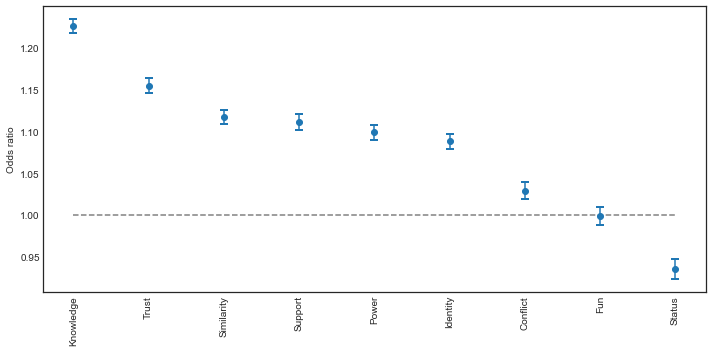

In [13]:
def plot_features(results, path):
    plt.style.use('seaborn-white')
    ordering_perm = sorted(range(1, len(results.params)),
                           key=results.params.values.__getitem__, reverse=True)
    plt.figure(figsize=(10, 5))
    plt.errorbar(
        x=np.arange(len(results.params)-1),
        y=np.exp(results.params.values[ordering_perm]),
        yerr=np.abs((results.conf_int().values.T - 
                     results.params.values.T)[:, ordering_perm]),
        fmt='o',
        capthick=2, capsize=4,
    )
    plt.plot([0, len(results.params)-2], [1, 1], '--', c='gray')
    plt.xticks(np.arange(len(results.params)-1), 
               [nice_columns(t) for t in results.params.index[ordering_perm]],
               rotation=90)
    plt.ylabel("Odds ratio")
    plt.tight_layout()
    plt.savefig(path)
    plt.show()

plot_features(base_model_results, "../paper/fig/comments-social-dim-log-reg.pdf")

### We subselect DIMS that are significative

In [14]:
DIMS = list(np.array(list(base_model_results.pvalues.index))[
    statsmodels.stats.multitest.multipletests(
        base_model_results.pvalues, 
        alpha=0.01,
        method='fdr_by',
    )[0]
])
DIMS.remove('Intercept')
DIMS = [d.replace('_weighted_comment_z', '') for d in DIMS]
DIMS

['support',
 'knowledge',
 'conflict',
 'power',
 'similarity',
 'status',
 'trust',
 'identity']

# Homophily Matrix

In [15]:
np.random.seed(1234)

In [16]:
homophily_matrix_results = smf.logit(
    formula=(
        "has_delta ~ " + 
        ' + '.join([c + '_weighted_comment' for c in DIMS]) + 
        " + post_leftwing + post_rightwing" + 
        " + post_leftwing*comment_leftwing" +  
        " + post_leftwing*comment_rightwing" + 
        " + post_rightwing*comment_leftwing" +  
        " + post_rightwing*comment_rightwing" + 
        ""
    ),
    data=df
).fit()
add_results_to_table(homophily_matrix_results).transpose()

Optimization terminated successfully.
         Current function value: 0.056644
         Iterations 10


,0
Adj. Pseudo-$R^2$,0.01968
Intercept,0.008***
post_leftwing[T.True],1.017
post_rightwing[T.True],0.962*
comment_leftwing[T.True],1.207***
comment_rightwing[T.True],0.948**
post_leftwing[T.True]:comment_leftwing[T.True],0.321***
post_leftwing[T.True]:comment_rightwing[T.True],1.197***
post_rightwing[T.True]:comment_leftwing[T.True],1.251***
post_rightwing[T.True]:comment_rightwing[T.True],0.391***


In [17]:
intercept = homophily_matrix_results.params['Intercept']

post_l = homophily_matrix_results.params['post_leftwing[T.True]']
post_r = homophily_matrix_results.params['post_rightwing[T.True]']
comm_l = homophily_matrix_results.params['comment_leftwing[T.True]']
comm_r = homophily_matrix_results.params['comment_rightwing[T.True]']

post_l_comm_l = homophily_matrix_results.params['post_leftwing[T.True]:comment_leftwing[T.True]']
post_l_comm_r = homophily_matrix_results.params['post_leftwing[T.True]:comment_rightwing[T.True]']
post_r_comm_l = homophily_matrix_results.params['post_rightwing[T.True]:comment_leftwing[T.True]']
post_r_comm_r = homophily_matrix_results.params['post_rightwing[T.True]:comment_rightwing[T.True]']

In [18]:
intercept = 0.
matrix_index = pd.MultiIndex.from_tuples(
    [('L', 'L'), ('L', 'R'), ('L', 'N'), 
     ('R', 'L'), ('R', 'R'), ('R', 'N'),
     ('N', 'L'), ('N', 'R'), ('N', 'N'),
    ],
    names=['post', 'comment'])
base_matrix = np.exp(pd.DataFrame(index=matrix_index, columns=['Odds ratio'], data=[
    intercept + post_l + comm_l + post_l_comm_l,
    intercept +     post_l + comm_r + post_l_comm_r, 
    intercept +         post_l,
    intercept + post_r + comm_l + post_r_comm_l,
    intercept +     post_r + comm_r + post_r_comm_r, 
    intercept +         post_r, 
    intercept + comm_l,
    intercept + comm_r,
    intercept
]))
base_matrix

Odds ratio
post comment            
L    L          0.393903
     R          1.154707
     N          1.017022
R    L          1.452263
     R          0.356122
     N          0.961589
N    L          1.207392
     R          0.948348
     N          1.000000

In [19]:
homophily_matrix_df = base_matrix.reset_index().pivot(
    index='post', columns='comment', values='Odds ratio')

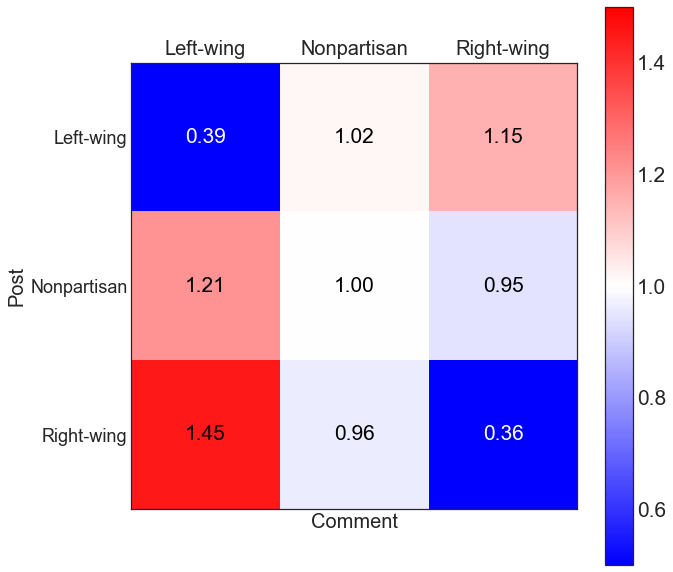

In [20]:
rename = {'L': 'Left-wing', 'R': 'Right-wing', 'N': 'Nonpartisan'}
matplotlib.rcParams.update({'font.size': 21})
fontsize = 20
fnum = plt.figure(figsize=(10, 10))
plt.matshow(homophily_matrix_df.values, fignum=fnum.number, cmap='bwr', vmin=0.5, vmax=1.5)
plt.colorbar()
plt.yticks(np.arange(3), [rename[c] for c in homophily_matrix_df.index],
           rotation=0., fontsize=(fontsize-2))
plt.xticks(np.arange(3), [rename[c] for c in homophily_matrix_df.columns],
           rotation=0., fontsize=fontsize)
plt.ylabel(homophily_matrix_df.index.name.title(), fontsize=fontsize)
plt.xlabel(homophily_matrix_df.columns.name.title(), fontsize=fontsize)

for (i, j), value in np.ndenumerate(homophily_matrix_df.values.T):
    plt.text(i, j, f"{value:.2f}", {
        'color': 'white' if value < 0.8 else 'black'
    }, va="center", ha="center", )

plt.savefig("../paper/fig/homophily-matrix.pdf")
plt.show()

# The big table

In [21]:
def run_log_reg(common_factors=''):
    np.random.seed(1234)
    homophily_results_df = None
    sentiments = "sentiment_pos_weighted_comment_z + sentiment_neg_weighted_comment_z"
    for confounders, use_social_dim in tqdm([
        (f"{sentiments}", False), 
        (f"{sentiments} + post_leftwing + post_rightwing + comment_leftwing + comment_rightwing", False),
        (f"{sentiments} + shared_sub", False),
        (f"{sentiments} + both_polarized + diff_side + both_polarized*diff_side", False),
        (f"{sentiments}", True), 
        (f"{sentiments} + post_leftwing + post_rightwing + comment_leftwing + comment_rightwing", True),
        (f"{sentiments} + shared_sub", True),
        (f"{sentiments} + both_polarized + diff_side + both_polarized*diff_side", True),
    ]):
        formula = "has_delta ~ " + common_factors
        if use_social_dim:
            formula += ' + '.join([c + '_weighted_comment_z' for c in DIMS])
        if confounders:
            formula += (" + " + confounders)
        homophily_results = smf.logit(formula=formula, data=df).fit()
        homophily_results_df = add_results_to_table(homophily_results, homophily_results_df)
    return homophily_results_df

homophily_results_df = run_log_reg()

  0%|          | 0/8 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 0.057609
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.057526
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.057244
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.057368
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.056833
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.056753
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.056473
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.056598
         Iterations 10


In [22]:
homophily_results_table = homophily_results_df.sort_values(by='Adj. Pseudo-$R^2$').copy()
homophily_results_table.columns = [nice_columns(t) for t in homophily_results_table.columns]
homophily_results_table[homophily_results_table.isna()] = ""
homophily_results_table = homophily_results_table.transpose()
homophily_results_table.columns = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"[:len(homophily_results_table.columns)])

In [23]:
homophily_results_table = homophily_results_table.reindex([
    'Adj. Pseudo-$R^2$', 'Intercept', 
    'Support', 'Knowledge', 'Conflict', 'Power', 'Similarity', 'Status', 'Trust', 'Identity',
    'Sentiment Pos.', 'Sentiment Neg.',
    'Comment Left-Wing', 'Comment Right-Wing', 'Post Left-Wing', 'Post Right-Wing',
    'Both Polarized', 'Both Polarized \& Diff. Side', 'Diff. Side', 
    'Shared Group',
    ])
homophily_results_table

,A,B,C,D,E,F,G,H
Adj. Pseudo-$R^2$,0.00305,0.00446,0.00720,0.00935,0.01643,0.01780,0.02050,0.02265
Intercept,0.010***,0.011***,0.011***,0.011***,0.010***,0.010***,0.010***,0.010***
Support,,,,,1.096***,1.095***,1.097***,1.098***
Knowledge,,,,,1.217***,1.216***,1.216***,1.216***
Conflict,,,,,1.024***,1.026***,1.025***,1.024***
Power,,,,,1.097***,1.099***,1.097***,1.096***
Similarity,,,,,1.110***,1.108***,1.110***,1.112***
Status,,,,,0.930***,0.929***,0.934***,0.937***
Trust,,,,,1.143***,1.143***,1.144***,1.144***
Identity,,,,,1.085***,1.086***,1.086***,1.086***


In [24]:
latex_table = (homophily_results_table
               .applymap(lambda x: x if x != '' else r'\dotfill')
               .to_latex(header=True, escape=False)
              )
latex_table = re.sub(r'(Adj. Pseudo.*\\\\)', r'\1 \\midrule', latex_table)
latex_table = re.sub(r'(Adj. Pseudo.*\\\\)', r'\1 \\midrule', latex_table)
latex_table = re.sub(r'(Intercept.*\\\\)', r'\1 \\addlinespace', latex_table)
latex_table = re.sub(r'(Identity.*\\\\)', r'\1 \\addlinespace', latex_table)
latex_table = re.sub(r'(Sentiment Neg.*\\\\)', r'\1 \\addlinespace', latex_table)
latex_table = re.sub(r'(Post Right-Wing.*\\\\)', r'\1 \\addlinespace', latex_table)
latex_table = re.sub(r'(Diff side.*\\\\)', r'\1 \\addlinespace', latex_table)
with open("../paper/tables/homophily-log-reg.tex", 'w') as f:
    f.write(latex_table)

### The Big Table in SI

In [23]:
alt_results_df = run_log_reg(common_factors='log_length_z + ')

  0%|          | 0/8 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: 0.053799
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.053708
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.053463
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.053575
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.053713
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.053625
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.053382
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.053494
         Iterations 10


In [28]:
alt_results_table = alt_results_df.copy()
alt_results_table.columns = [nice_columns(t) for t in alt_results_table.columns]
alt_results_table[alt_results_table.isna()] = ""
alt_results_table = alt_results_table.transpose()
alt_results_table.columns = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ"[:len(alt_results_table.columns)])
alt_results_table

,A,B,C,D,E,F,G,H
Adj. Pseudo-$R^2$,0.06898,0.07054,0.07479,0.07283,0.07042,0.07193,0.07615,0.07421
Intercept,0.007***,0.007***,0.007***,0.007***,0.007***,0.007***,0.007***,0.007***
Log Length,2.929***,2.929***,2.905***,2.914***,2.904***,2.906***,2.879***,2.890***
Sentiment Pos.,1.054***,1.052***,1.056***,1.054***,1.043***,1.042***,1.044***,1.042***
Sentiment Neg.,0.979***,0.981**,0.980***,0.980***,0.996,0.998,0.997,0.997
Comment Left-Wing,,0.984,,,,0.983,,
Comment Right-Wing,,0.772***,,,,0.776***,,
Post Left-Wing,,0.878***,,,,0.880***,,
Post Right-Wing,,0.847***,,,,0.846***,,
Shared Group,,,0.297***,,,,0.299***,


In [29]:
alt_results_table.index

Index(['Adj. Pseudo-$R^2$', 'Intercept', 'Log Length', 'Sentiment Pos.',
       'Sentiment Neg.', 'Comment Left-Wing', 'Comment Right-Wing',
       'Post Left-Wing', 'Post Right-Wing', 'Shared Group', 'Both Polarized',
       'Both Polarized \& Diff. Side', 'Diff. Side', 'Conflict', 'Identity',
       'Knowledge', 'Power', 'Similarity', 'Status', 'Support', 'Trust'],
      dtype='object')

In [30]:
alt_results_table = alt_results_table.reindex([
    'Adj. Pseudo-$R^2$', 'Intercept', 
    'Support', 'Knowledge', 'Conflict', 'Power', 'Similarity', 'Status', 'Trust', 'Identity',
    'Sentiment Pos.', 'Sentiment Neg.',
    'Comment Left-Wing', 'Comment Right-Wing', 'Post Left-Wing', 'Post Right-Wing',
    'Both Polarized', 'Both Polarized \& Diff. Side', 'Diff. Side', 
    'Shared Group',
    'Log Length',
    ])
alt_results_table

,A,B,C,D,E,F,G,H
Adj. Pseudo-$R^2$,0.06898,0.07054,0.07479,0.07283,0.07042,0.07193,0.07615,0.07421
Intercept,0.007***,0.007***,0.007***,0.007***,0.007***,0.007***,0.007***,0.007***
Support,,,,,1.033***,1.032***,1.034***,1.033***
Knowledge,,,,,1.066***,1.065***,1.066***,1.065***
Conflict,,,,,0.925***,0.927***,0.926***,0.926***
Power,,,,,0.974***,0.976***,0.973***,0.974***
Similarity,,,,,0.988*,0.986**,0.989*,0.988*
Status,,,,,0.916***,0.915***,0.923***,0.920***
Trust,,,,,1.051***,1.050***,1.050***,1.050***
Identity,,,,,0.999,0.999,0.999,0.999


In [31]:
alt_latex_table = (alt_results_table
               .applymap(lambda x: x if x != '' else r'\dotfill')
               .to_latex(header=True, escape=False)
              )
alt_latex_table = re.sub(r'(Adj. Pseudo.*\\\\)', r'\1 \\midrule', alt_latex_table)
alt_latex_table = re.sub(r'(Adj. Pseudo.*\\\\)', r'\1 \\midrule', alt_latex_table)
alt_latex_table = re.sub(r'(Intercept.*\\\\)', r'\1 \\addlinespace', alt_latex_table)
alt_latex_table = re.sub(r'(Identity.*\\\\)', r'\1 \\addlinespace', alt_latex_table)
alt_latex_table = re.sub(r'(Sentiment Neg.*\\\\)', r'\1 \\addlinespace', alt_latex_table)
alt_latex_table = re.sub(r'(Post Right-Wing.*\\\\)', r'\1 \\addlinespace', alt_latex_table)
alt_latex_table = re.sub(r'(Diff side.*\\\\)', r'\1 \\addlinespace', alt_latex_table)
alt_latex_table = re.sub(r'(Shared group.*\\\\)', r'\1 \\addlinespace', alt_latex_table)
with open("../paper/tables/homophily-log-reg-length.tex", 'w') as f:
    f.write(alt_latex_table)